In [1]:
from pcgen.molecules.paths import CKPT_DIR
from pcgen.molecules.utils import load_model_from_ckpt_path
from pcgen.molecules.data.datasets import MosesDataset
from rdkit import Chem
import torch
import numpy as np

In [2]:
# use GPU is cuda is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model_from_ckpt_path(CKPT_DIR + '/checkpoint_moses.ckpt', map_location=device)

Found rdkit, all good
Marginal distribution of the classes: tensor([0.5664, 0.1071, 0.1283, 0.0812, 0.1115, 0.0042, 0.0012, 0.0000],
       device='cuda:0') for nodes, tensor([8.4956e-01, 4.4773e-02, 5.9329e-02, 3.3361e-04, 4.6009e-02],
       device='cuda:0') for edges


CCOC(=O)c1ncn2c1CN(C)C(=O)c1cc(F)ccc1-2


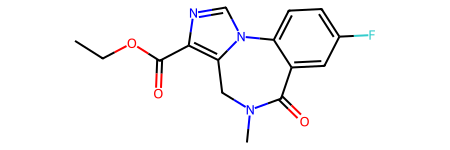

In [3]:
# load moses test set
dataset = MosesDataset(repr='mol')
#idx = 3
idx = 2
example = dataset[idx]
from pcgen.molecules.data.conversions import smiles_to_mol, mol_to_smiles
#example = smiles_to_mol("COC(=O)C(C1CCCCN1)C2=CC=CC=C2")
print(mol_to_smiles(example))
example

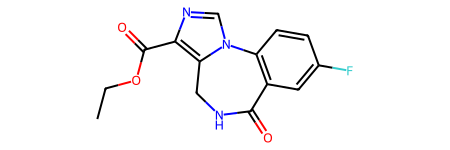

In [4]:
# extract Murcko scaffold
from pcgen.molecules.data.fragment_gen import extract_murcko_scaffold
from pcgen.molecules.data.fragment_gen import remove_atom
from rdkit.Chem import QED
scaffold = remove_atom(example)[0]
#scaffold = smiles_to_mol("CCOC(=O)c1ncn2c1CN(C)C(=0)c1cc(F)ccc1-2")
#from rdkit.Chem import BRICS
#fragments = BRICS.BRICSDecompose(example)
#print(fragments)
#fragments = Chem.GetMolFrags(example, asMols=False, sanitizeFrags=True)
#scaffold = remove_atom(example)[0]
#scaffold = smiles_to_mol("OC(Cn1cncn1)c1ccc(F)cc1F")
scaffold

In [5]:
from pcgen.molecules.data.conversions import tuple_to_mol, mol_to_tuple
from pcgen.molecules.data.base import squeeze, subtract_arrays, count_atom_types
import torch
#left_over = subtract_arrays(mol_to_tuple(example)[0][0], mol_to_tuple(scaffold)[0][0])
samples = model.sample(num_samples=60, cond=(mol_to_tuple(scaffold), example.GetNumAtoms()))
#samples = model.sample(num_samples=128, cond=(squeeze((torch.cat([mol_to_tuple(scaffold)[0][0], left_over]), mol_to_tuple(scaffold)[1])), example.GetNumAtoms()))
#samples = model.sample(num_samples=128, cond=(squeeze((torch.cat([mol_to_tuple(scaffold)[0][0], left_over]), mol_to_tuple(scaffold)[1])), count_atom_types(example)))
#left_over[0]

In [6]:
from pcgen.molecules.data.conversions import clean_and_convert_samples
cleaned_samples = clean_and_convert_samples(samples)

In [7]:
len(cleaned_samples)

15

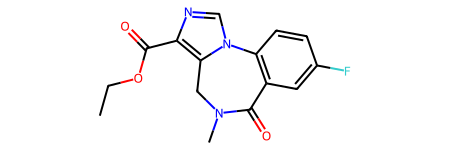

In [8]:
cleaned_samples[0]

In [10]:
for sample in cleaned_samples:
    print(QED.qed(sample))

0.793247744649229
0.8589207198736821
0.8577103644389892
0.6541647689572588
0.8577103644389892
0.6900887113122001
0.8322799209379697
0.8067995518398599
0.8338408013032772
0.8611530213990672
0.7913408885823977
0.8577103644389892
0.8577103644389892
0.8778761562511369
0.8548230006752523


In [11]:
len(dataset)

176074

(array([1., 0., 1., 0., 0., 0., 0., 6., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        5., 0., 0., 1., 0., 5., 5., 1., 0., 4., 5., 5., 8., 1., 0., 4., 5.,
        3., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 2.]),
 array([0.46986715, 0.47942358, 0.48898002, 0.49853645, 0.50809289,
        0.51764933, 0.52720576, 0.5367622 , 0.54631863, 0.55587507,
        0.5654315 , 0.57498794, 0.58454437, 0.59410081, 0.60365725,
        0.61321368, 0.62277012, 0.63232655, 0.64188299, 0.65143942,
        0.66099586, 0.67055229, 0.68010873, 0.68966517, 0.6992216 ,
        0.70877804, 0.71833447, 0.72789091, 0.73744734, 0.74700378,
        0.75656021, 0.76611665, 0.77567309, 0.78522952, 0.79478596,
        0.80434239, 0.81389883, 0.82345526, 0.8330117 , 0.84256813,
        0.85212457, 0.86168101, 0.87123744, 0.88079388, 0.89035031,
        0.89990675, 0.90946318, 0.91901962, 0.92857605, 0.93813249,
        0.94768893]),
 <BarContainer object of 50 artists>)

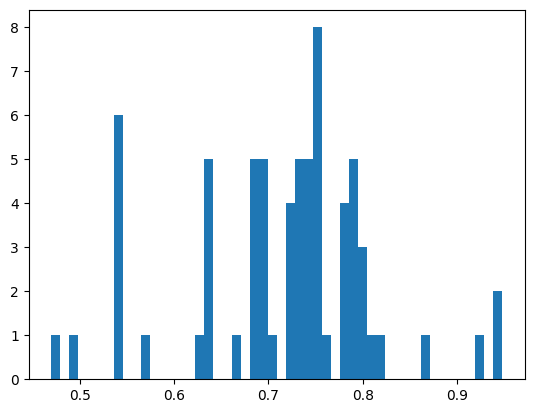

In [85]:
# compute histogram over SAS scores of generated examples
from rdkit.Chem import QED
qed_scores = [QED.qed(s) for s in cleaned_samples]
qed_scores = np.array(qed_scores)
import matplotlib.pyplot as plt
plt.hist(qed_scores, bins=50)